<a href="https://colab.research.google.com/github/PRAN20/Recommendation-System/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Header Files**

In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

# **Importing DataSet**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx')
#/content/drive/MyDrive/Online Retail.xlsx

# **Checking Dataset**

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

# **Removing Missing Values**

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# **Data Preparation**

In [ ]:
df['StockCode']= df['StockCode'].astype(str)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
customers = df["CustomerID"].unique().tolist()   #Unique Customers
len(customers)

4372

In [ ]:
random.shuffle(customers)

In [ ]:
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

In [ ]:
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

# **Storing Total Purchases in a List**

In [ ]:
purchases_train = []

for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:03<00:00, 1005.91it/s]


In [ ]:
purchases_val = []

for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1531.91it/s]


# **Word2vec Model**

In [ ]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3648739, 3684830)

In [ ]:
model.save("/content/Output/word2vec_2.model") #Most Important

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3175, size=100, alpha=0.03)


# **Constructing UMAP of the Model**

In [ ]:
!pip uninstall umap
!pip install umap-learn

In [ ]:
X = model[model.wv.vocab]
X.shape

(3175, 100)

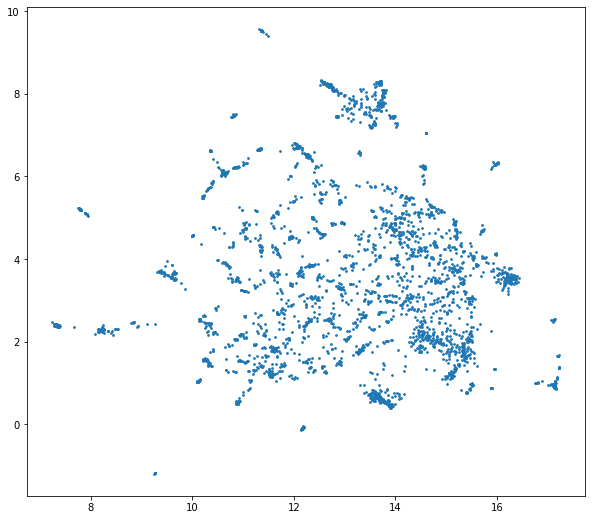

In [ ]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

# **Recomedation Phase**

In [ ]:
products = train_df[["StockCode", "Description"]]
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [ ]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [ ]:
def similar_products(v, n = 6):
    
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [ ]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7877718210220337),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.78275066614151),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7807952165603638),
 ('PINK BOUDICCA LARGE BRACELET', 0.7596126794815063),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.7594028115272522),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7572386860847473)]

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [ ]:
similar_products(aggregate_vectors(purchases_val[0]))

[('JUMBO BAG ALPHABET', 0.8001401424407959),
 ('LUNCH BAG ALPHABET DESIGN', 0.7942807674407959),
 ('JUMBO BAG VINTAGE LEAF', 0.7738019227981567),
 ('JUMBO BAG APPLES', 0.7732822895050049),
 ('JUMBO BAG SPACEBOY DESIGN', 0.7651514410972595),
 ('JUMBO BAG PEARS', 0.7638946771621704)]

In [ ]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('JUMBO BAG VINTAGE CHRISTMAS ', 0.7463159561157227),
 ("JUMBO BAG 50'S CHRISTMAS ", 0.7412354946136475),
 ('VINTAGE DOILY JUMBO BAG RED ', 0.6707476377487183),
 ('JUMBO BAG VINTAGE LEAF', 0.6696573495864868),
 ('JUMBO BAG PAISLEY PARK', 0.6615587472915649),
 ('JINGLE BELL HEART DECORATION', 0.6535539031028748)]

In [ ]:
Datset - 1GB
#IEE Kaggle 
-SQL, PIG - 80

Model Save

Backend - 